<a href="https://colab.research.google.com/github/NiyonshutiDavid/Kaggle_competition_ML-air_quality_forcasting/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/ALU-Course_Documents/Machine learning Techniques/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ALU-Course_Documents/Machine learning Techniques/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure by previewing the first 5 rows of the dataset,
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
# Displaying all columns of the dataset and describing the datatypes of each column
print("\nColumn Information:")
train.info()
print("\n \nData Types:")
print(train.dtypes)
print("\n \nDataset Columns")
train.columns


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB

 
Data Types:
No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype:

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


In [7]:
# Display descriptive statistics of the training data to understand the distribution of numerical features
print("\nDescriptive Statistics:")
display(train.describe())


Descriptive Statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


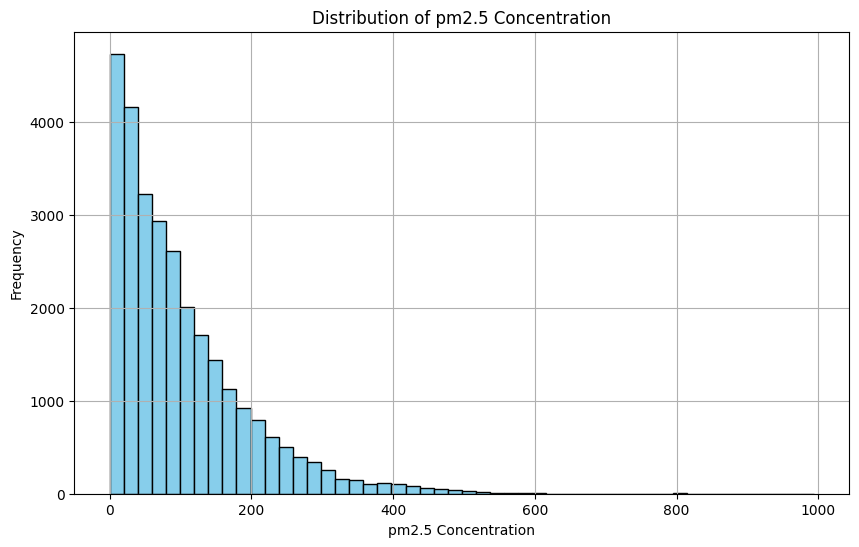

In [8]:
# Visualize the distribution of the target variable 'pm2.5'
plt.figure(figsize=(10, 6))
plt.hist(train['pm2.5'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of pm2.5 Concentration')
plt.xlabel('pm2.5 Concentration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

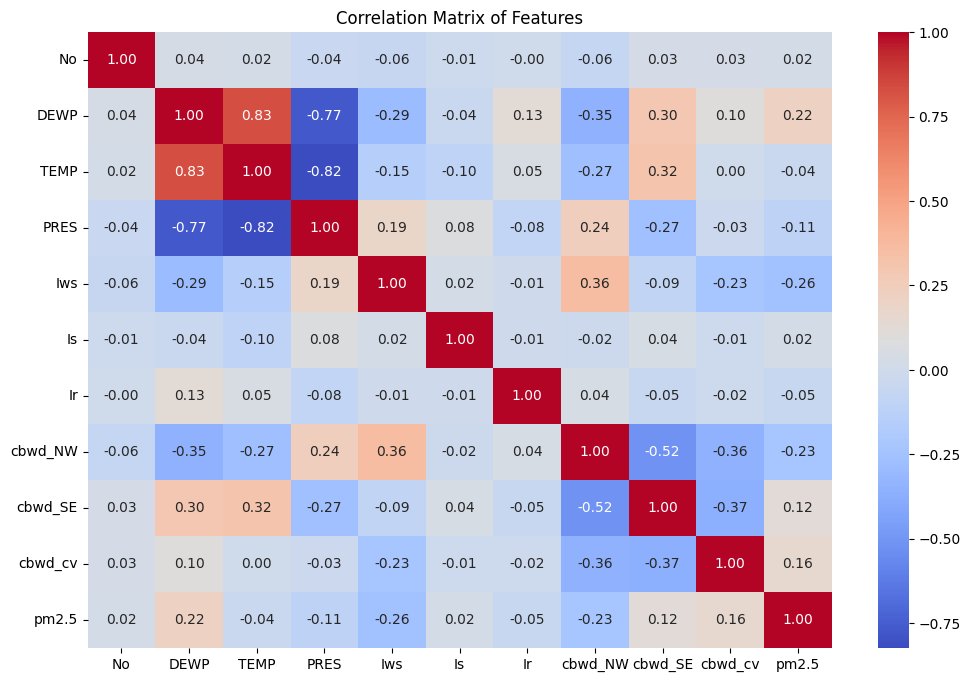

In [9]:
# Visualize the correlation matrix to understand relationships between features
import seaborn as sns

plt.figure(figsize=(12, 8))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

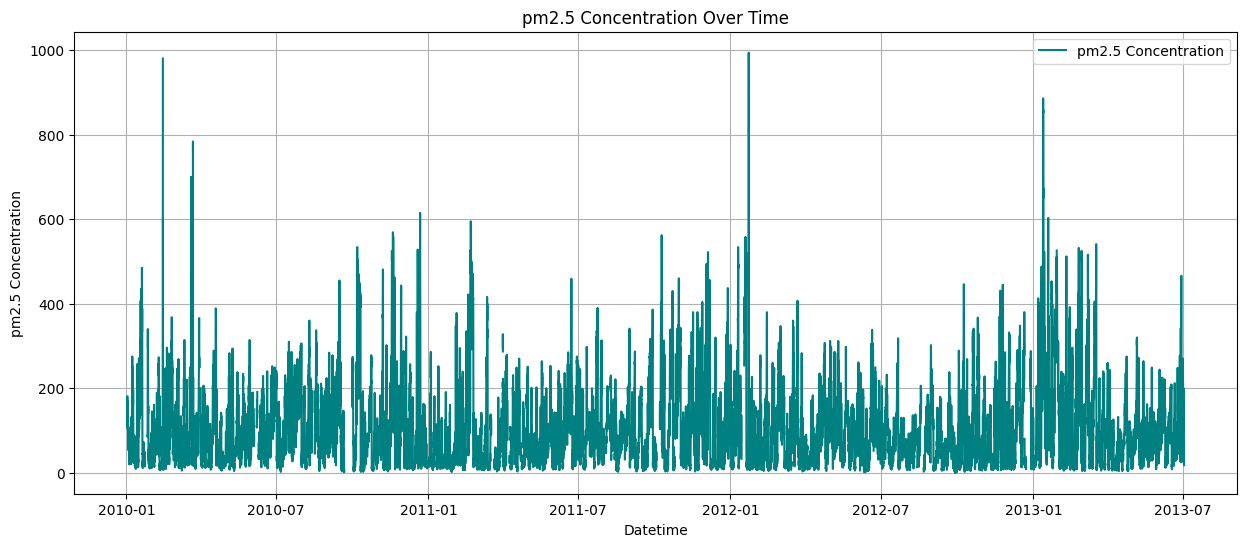

In [10]:
# Visualize the time series of 'pm2.5' concentration
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['pm2.5'], color='teal', label='pm2.5 Concentration')
plt.title('pm2.5 Concentration Over Time')
plt.xlabel('Datetime')
plt.ylabel('pm2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Attempt to automatically identify timestamp and target columns
timestamp_column = None
target_column = None

# Check for a column with 'datetime' in its name and datetime dtype
for col in train.columns:
    if 'datetime' in col.lower() or train[col].dtype == 'datetime64[ns]':
        timestamp_column = col
        break

# Check for a 'pm2.5' column or a column with 'pm2.5' or 'target' in its name and numeric dtype
for col in train.columns:
    if col.lower() == 'pm2.5' or ('pm2.5' in col.lower() or 'target' in col.lower()) and pd.api.types.is_numeric_dtype(train[col]):
        target_column = col
        break

if timestamp_column and target_column:
    print(f"Identified timestamp column: {timestamp_column}")
    print(f"Identified target column: {target_column}")

    # Set the timestamp column as index if it's not already
    if train.index.name != timestamp_column:
        train.set_index(timestamp_column, inplace=True)

    # Simple time-series plot of the target column
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train[target_column], color='teal', label=target_column)
    plt.title(f'{target_column} Over Time')
    plt.xlabel('Datetime')
    plt.ylabel(target_column)
    plt.legend()
    plt.grid(True)
    plt.show()
elif target_column:
    print(f"Identified target column: {target_column}")
    print("No clear timestamp column found, skipping time-series plot.")
elif timestamp_column:
    print(f"Identified timestamp column: {timestamp_column}")
    print("No target column ('pm2.5' or 'target') found, skipping time-series plot.")
else:
    print("Could not automatically identify timestamp or target columns.")

Identified target column: pm2.5
No clear timestamp column found, skipping time-series plot.


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [12]:
print('\nMissing values per column:')
display(train.isna().sum().sort_values(ascending=False).head(20))


Missing values per column:


,0
pm2.5,1921
DEWP,0
No,0
TEMP,0
PRES,0
Is,0
Iws,0
Ir,0
cbwd_NW,0
cbwd_SE,0


In [13]:
# Handling missing data using interpolation
train.interpolate(method='linear', inplace=True)
print('\nMissing values per column after interpolation:')
display(train.isna().sum().sort_values(ascending=False).head(20))



Missing values per column after interpolation:


,0
pm2.5,24
DEWP,0
No,0
TEMP,0
PRES,0
Is,0
Iws,0
Ir,0
cbwd_NW,0
cbwd_SE,0


In [14]:
# Then fix missing values using forward fill and backward fill after interpolating the dataset
train.fillna(method='ffill', inplace=True)
train.fillna(method='bfill', inplace=True)
print('\nMissing values per column after filling with forward and backward fill:')
display(train.isna().sum().sort_values(ascending=False).head(20))


Missing values per column after filling with forward and backward fill:


/tmp/ipython-input-3094893053.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3094893053.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='bfill', inplace=True)


,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [15]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [16]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.

# Convert DataFrame to numpy arrays
X = X_train.values
y = y_train.values

# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])   # past `time_steps` rows
        ys.append(y[i + time_steps])       # predict the next value
    return np.array(Xs), np.array(ys)

# Use past 24 hours
time_steps = 24
X_seq, y_seq = create_sequences(X, y, time_steps)

# Split into train and validation
split = int(0.8 * len(X_seq))
X_train, y_train = X_seq[:split], y_seq[:split]
X_val, y_val = X_seq[split:], y_seq[split:]

print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (24521, 24, 9)
y_train shape: (24521,)
X_val shape: (6131, 24, 9)
y_val shape: (6131,)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [17]:
# define model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
                  input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)   # regression output
])

# Define RMSE as a metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[rmse])

# Display model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 128)        │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,849 (245.50 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 64 (256.00 B)

In [18]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)

In [19]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,   # automatically splits 20% for validation
    callbacks=[early_stop, lr_reduction],
    verbose=1
)

Epoch 1/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - loss: 9777.3555 - rmse: 114.6514 - val_loss: 2955.9353 - val_rmse: 55.2044 - learning_rate: 0.0010
Epoch 2/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - loss: 4836.8452 - rmse: 106.1782 - val_loss: 4331.5640 - val_rmse: 66.1466 - learning_rate: 0.0010
Epoch 3/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 4674.8232 - rmse: 108.8809 - val_loss: 3636.5002 - val_rmse: 61.2859 - learning_rate: 0.0010
Epoch 4/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - loss: 4543.4082 - rmse: 110.5741 - val_loss: 3710.5957 - val_rmse: 60.5927 - learning_rate: 0.0010
Epoch 5/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 4193.5459 - rmse: 111.4047 - val_loss: 4504.0840 - val_rmse: 65.3862 - learning_rate: 0.0010
Epoch 6/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - loss: 4263.5479 - rmse: 112.2681 - val_loss: 3643.9312 - val_rmse: 60.9774 - learning_rate: 0.0010
Epoch 7/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 3

767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


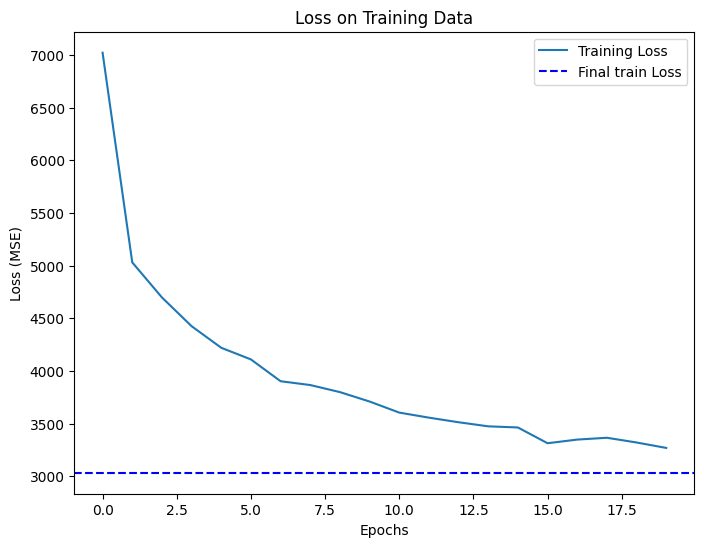

Final Training Loss (MSE): 3034.2411870867563


In [20]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [21]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/ALU-Course_Documents/Machine learning Techniques/Kaggle_competition_ML/air_quality_forcasting/submission_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
